# Packages

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
from keras.layers import LSTM

In [4]:
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [5]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop

In [6]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score

In [7]:
import matplotlib.pyplot as plt

In [8]:
#from keras.utils.vis_utils import plot_model

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
#!pip install optuna
import optuna
from optuna import trial
from optuna.visualization import plot_optimization_history

# Dataset

In [11]:
df = pd.read_csv('DataSets /WORLD-OWID-Features')

In [12]:
df.set_index('year', inplace=True)

In [13]:
mean_co2 = df.loc[[2019, 2021], 'co2'].mean()
df.loc[2020, 'co2'] = mean_co2

In [14]:
#df.index = pd.to_datetime(df.index, format="%Y")

In [16]:
#start_year = pd.to_datetime('1880-01-01')

df = df.loc[1880:]

df.head(5)

,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
year,,,,,,,,
1880,0.0,853.705,838.340,256.309556,1814.698707,3100.721,15.364,82.069576
1881,0.0,882.405,865.162,256.309556,1814.698707,3096.935,17.242,82.069576
1882,0.0,931.922,912.817,256.309556,0.165000,3159.833,18.939,82.069576
1883,0.0,991.032,974.149,256.309556,0.381000,3220.534,16.502,82.069576
1884,0.0,1002.174,982.679,256.309556,1.172000,3240.197,18.323,82.069576


As we can see tha value of 2020 is an outlier compared to the other years because of corona... We will change this value with the mean of 2019 and 2021 combined. This way our future predictions/foreastings will be more accurate. 

# defining our train, test and val set 

In [17]:
train_set = df[(df.index > 1879) & (df.index <= 2000)]
test_set = df[(df.index > 2000) & (df.index <= 2011)]
validate_set = df[df.index > 2011]

print("Train set:")
print(train_set.index.min(), "to", train_set.index.max())

print("Test set:")
print(test_set.index.min(), "to", test_set.index.max())

print("Validation set:")
print(validate_set.index.min(), "to", validate_set.index.max())

Train set:
1880 to 2000
Test set:
2001 to 2011
Validation set:
2012 to 2021


In [18]:
train_data = train_set['co2'].tolist()
test_data = test_set['co2'].tolist()
val_data = validate_set['co2'].tolist()

# Creating our lookback window

In [19]:
def to_sequences(seq_size, obs):

  x = []
  y = []

  for i in range(len(obs)-SEQUENCE_SIZE):
    #print(i)
    window = obs[i:(i+SEQUENCE_SIZE)]
    after_window = obs[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
    y.append(after_window)
        
  return np.array(x),np.array(y)

SEQUENCE_SIZE = 5
x_train,y_train = to_sequences(SEQUENCE_SIZE, train_data)
x_test,y_test = to_sequences(SEQUENCE_SIZE, test_data)
x_val, y_val = to_sequences(SEQUENCE_SIZE, val_data)

print("Shape of x training set: {}".format(x_train.shape))
print("Shape of x test set: {}".format(x_test.shape))
print("Shape of x val set: {}".format(x_val.shape))

Shape of x training set: (116, 5, 1)
Shape of x test set: (6, 5, 1)
Shape of x val set: (5, 5, 1)


In [22]:
#len_test = len(df[df.index > 2000])

In [24]:
#X_train = X[len_test:]
#X_train.shape

In [ ]:
#X_test = X[:len_test]
#X_test.shape

In [ ]:
#y_train = y_window[len_test:]
#y_train.shape

In [25]:
#y_test = y_window[:len_test]
#y_test.shape

# Scaling our variables

In [ ]:
'''scaler_sx = MinMaxScaler(feature_range=(0,1))
scaler_sy = MinMaxScaler(feature_range=(0,1))

X_train_Scaled = scaler_sx.fit_transform(X_train)
X_test_Scaled = scaler_sx.transform(X_test)
y_train_Scaled = scaler_sy.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_Scaled = scaler_sy.transform(np.array(y_test).reshape(-1, 1))'''

# Evaluation & Visualization Helper Functions

In [26]:
def eval_metrics(y_test, y_pred):
  R2 = r2_score(y_test, y_pred)
  Max_error = max_error(y_test, y_pred)
  MAE = mean_absolute_error(y_test, y_pred)
  MAPE = mean_absolute_percentage_error(y_test, y_pred)
  return R2, Max_error, MAE, MAPE

In [27]:
def print_model_results(model_name,y_test,y_pred):
    R2, ME, MAE, MAPE = eval_metrics(y_test,y_pred)
    print(f'{model_name}:  R^2= {R2:.4f},  ME = {ME:.4f},  MAE = {MAE:.4f},  MAPE = {MAPE:.4f}')
    return None

In [28]:
def plot_results(model_name,y_test,y_pred):
    R2, ME, MAE, MAPE = eval_metrics(y_test,y_pred)
    df_plot = pd.DataFrame({'actual':y_test, 'predicted':y_pred})
    df_plot = df_plot.reset_index()
    df_plot = df_plot.drop(columns=['year'])
    date = pd.date_range(start='2000-01-01', end='2021-01-01')
    df_plot = df_plot.set_index(date)
    df_plot.plot()
    plt.ylabel('MtCO2 Value')
    plt.title(f' {model_name}:  R^2= {R2:.4f},  ME = {ME:.4f},  MAE = {MAE:.4f},  MAPE = {MAPE:.4f}')
    plt.ylim(84,111)

    #file_name =  f'{model_name:}.png'
    #plt.savefig(file_name)
    return None

# Hyperparameter Optimization using the Optuna Library



Optuna is an open-source hyperparameter optimization (HPO) library designed to automate the process of finding the best hyperparameters. It focuses on efficiently exploring the search space and prioritizing the most promising local minimums, it concentrates on areas with higher potential for better results, leading to faster convergence towards better solutions.

Picture for bettere explenation: photo on the **left** is **GridSearch**, photo on the **right** is **optuna**



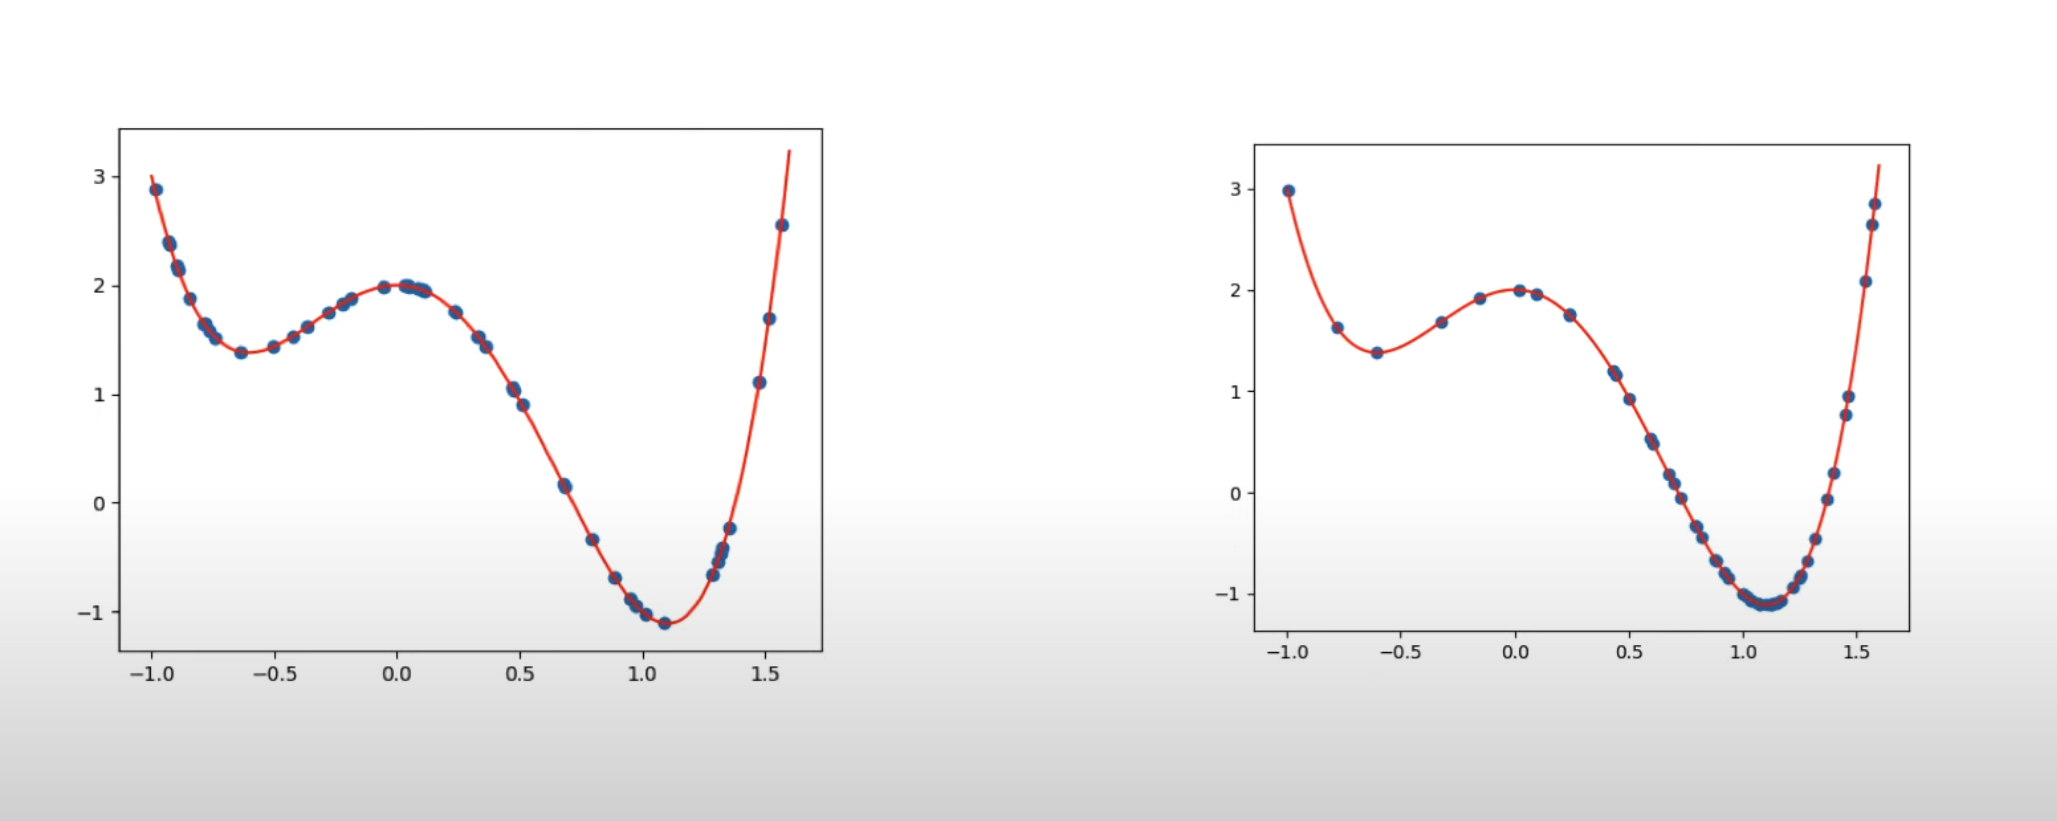

Used Resources:

https://optuna.readthedocs.io/en/stable/tutorial/index.html  
https://github.com/optuna

Using the optuna dashboard to visualize your trials:

https://github.com/optuna/optuna-dashboard


# All-in-one Method to find the best parameters

In [ ]:
def objective(trial):

  # Defining our search spaces
  n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3) # Amount of layers
  lstm_units = trial.suggest_int('lstm_units', 32, 256) # Amount of units
  optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd']) # ...
  n_epochs = trial.suggest_int('n_epochs', 5, 25)
  batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

  # creating our LSTM model
  model = Sequential()
  for i in range(n_lstm_layers):
    if i == 0:
      model.add(LSTM(lstm_units, input_shape=(3, 1), return_sequences=True))
    else:
      model.add(LSTM(lstm_units, return_sequences=True))
  model.add(LSTM(1, return_sequences=False))  # Make sure to not forget to add a layer with return_sequences=False when using this method, otherwise the dimensions won't be correct.
  model.add(Dense(1))

  # Compiling our model with specified optimizer
  if optimizer_name == 'adam':
    optimizer = Adam(learning_rate = trial.suggest_loguniform('Adam_learning_rate', 1e-5, 1e-1))
  elif optimizer_name == 'rmsprop':
    optimizer = RMSprop(learning_rate = trial.suggest_loguniform('RMSprop_learning_rate', 1e-5, 1e-1))
  else:
    optimizer = SGD(learning_rate = trial.suggest_loguniform('SGD_learning_rate', 1e-5, 1e-1))

  model.compile(loss='mean_absolute_error', optimizer=optimizer)

  # Training the model
  model.fit(X_train_Scaled, y_train_Scaled, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test_Scaled, y_test_Scaled), verbose=1)

  # Evaluating the model on the validation set
  y_pred_Scaled = model.predict(X_test_Scaled)
  print(y_pred_Scaled.shape)

  y_pred = scaler.inverse_transform(y_pred_Scaled)
  y_pred = y_pred.reshape(-1)


  print_model_results('Optuna_model', y_test, y_pred)
  R2, ME, MAE, MAPE = eval_metrics(y_test, y_pred)

  # Calculating the average metric scores
  average_metric = (R2 + ME + MAE + MAPE) / 4

  return average_metric

# Creating a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3) # define how much trials you want to do

# Printing best hyperparameters and corresponding metrics
print('Best trial:')
trial = study.best_trial
print(f'  Average Metric Score: {trial.value:.4f}')
print('  Hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Visualizing results
plot_optimization_history(study)

# Method to find the best parameters and also plot these already

In [42]:
def create_lstm_model(input_shape, n_lstm_layers, lstm_units, dropout, optimizer_name, learning_rate):
    model = Sequential()
    for i in range(n_lstm_layers):
        if i == 0:
            model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=True))
        else:
            model.add(LSTM(lstm_units, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(LSTM(1, return_sequences=False))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer=optimizer)
    
    return model

In [43]:
def objective(trial):
    input_shape = x_train.shape[1:]

    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 5)
    lstm_units = trial.suggest_int("lstm_units", 32, 256)
    dropout = trial.suggest_float("dropout", 0.15, 0.35)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 16, 64)

    model = create_lstm_model(
        input_shape,
        n_lstm_layers=n_lstm_layers,
        lstm_units=lstm_units,
        dropout=dropout,
        optimizer_name="adam",
        learning_rate=learning_rate
    )

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=n_epochs,
        batch_size=64,
        callbacks=callbacks,
    )

    loss = model.evaluate(x_test, y_test, verbose=1)
    return loss

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-08-15 19:18:31,906] A new study created in memory with name: no-name-43c92a05-1758-4937-875f-377335ce0609


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 201)            163212    
                                                                 
 dropout_54 (Dropout)        (None, 5, 201)            0         
                                                                 
 lstm_55 (LSTM)              (None, 5, 201)            324012    
                                                                 
 dropout_55 (Dropout)        (None, 5, 201)            0         
                                                                 
 lstm_56 (LSTM)              (None, 5, 201)            324012    
                                                                 
 dropout_56 (Dropout)        (None, 5, 201)            0         
                                                                 
 lstm_57 (LSTM)              (None, 5, 201)          

[I 2023-08-15 19:18:38,554] Trial 0 finished with value: 32265.990234375 and parameters: {'n_lstm_layers': 5, 'lstm_units': 201, 'dropout': 0.1526666190837053, 'learning_rate': 0.00013780917254136297, 'n_epochs': 33}. Best is trial 0 with value: 32265.990234375.


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 219)            193596    
                                                                 
 dropout_59 (Dropout)        (None, 5, 219)            0         
                                                                 
 lstm_61 (LSTM)              (None, 5, 219)            384564    
                                                                 
 dropout_60 (Dropout)        (None, 5, 219)            0         
                                                                 
 lstm_62 (LSTM)              (None, 5, 219)            384564    
                                                                 
 dropout_61 (Dropout)        (None, 5, 219)            0         
                                                                 
 lstm_63 (LSTM)              (None, 1)               

[W 2023-08-15 19:18:41,290] Trial 1 failed with parameters: {'n_lstm_layers': 3, 'lstm_units': 219, 'dropout': 0.23187365962901663, 'learning_rate': 0.00045166281577728326, 'n_epochs': 29} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_87837/2295885721.py", line 23, in objective
    model.fit(
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py", line 1748, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/ke

KeyboardInterrupt: 

In [ ]:
all_trials = study.trials

trial_results = []

for trial in all_trials:
    trial_params = trial.params
    trial_value = trial.value
    trial_result = {**trial_params, "value": trial_value}
    trial_results.append(trial_result)

trial_results_df = pd.DataFrame(trial_results)

print(trial_results_df)

In [ ]:
best_params = study.best_params
best_loss = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")  

In [ ]:
# Create and compile the best model using the best hyperparameters
best_model = create_lstm_model(input_shape=x_train.shape[1:],
                               n_lstm_layers=best_params['n_lstm_layers'],
                               lstm_units=best_params['lstm_units'],
                               optimizer_name=best_params['optimizer'],
                               learning_rate=trial.params['learning_rate'])

In [ ]:
best_model.fit(x_train, y_train, epochs=best_params['n_epochs'], batch_size=best_params['batch_size'], verbose=1)

In [ ]:
pred = best_model.predict(x_test)

print_model_results('LSTM_model', y_test, pred)

In [ ]:
def create_best_trial_lstm_model(input_shape, lstm_units, learning_rate):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dense(1))
    random_seed=42

    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

# De beste hyperparameters uit de beste run
best_n_lstm_layers = 3
best_lstm_units = 206
best_learning_rate = 6.0667153787800135e-05

# Reshape het input_shape afhankelijk van je gegevens
input_shape = (7, 1)

# Maak het model met de beste hyperparameters
best_model = create_best_trial_lstm_model(input_shape, best_lstm_units, best_learning_rate)

# Train het beste model op het gehele trainingsset
best_n_epochs = 25
best_batch_size = 16

best_model.fit(X_train_Scaled, y_train_Scaled, epochs=best_n_epochs, batch_size=best_batch_size, verbose=1)

In [ ]:
y_pred_Scaled = best_model.predict(X_test_Scaled)
y_pred = scaler.inverse_transform(y_pred_Scaled).squeeze()

In [ ]:
print_model_results('LSTM_best_trial', y_test, y_pred)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.loc[df.index > '2000-01-01'].index, y_test.values, label='Actual')
plt.plot(df.loc[df.index > '2000-01-01'].index, y_pred, label='Predicted')
plt.xlabel('Tijdsindex')
plt.ylabel('CO2')
plt.legend()
plt.show()

# Using Optuna with RF Reggressor and SVR

In [ ]:
'''import optuna
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('regressor', ['SVR', 'RandomForest'])
    if regressor_name == 'SVR':
        svr_c = trial.suggest_float('svr_c', 1e-10, 1e10, log=True)
        regressor_obj = sklearn.svm.SVR(C=svr_c)
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)


    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    error = sklearn.metrics.mean_squared_error(y_test, y_pred)

    return error  # An objective value linked with the Trial object.

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.'''

# LSTM Autoregressive Model Building Manually

In [ ]:
'''model = Sequential()
model.add(Input(shape=(5, 1), dtype='float32'))
model.add(LSTM(64, activation='relu', kernel_initializer='he_normal', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='linear', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, activation='linear', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))'''

In [ ]:
'''optimizer = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimizer)
model.summary()'''

In [ ]:
'''img_file =  '_LSTM_1.jpg'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_activations=True, )'''

# Training LSTM model + Saving best weights Manually

In [ ]:
'''import os

# Set the checkpoint directory for saving weights
checkpoint_dir = "/content/keras_models"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the file path for saving weights
save_weights_at = os.path.join(checkpoint_dir, 'CarbonMonitor_World-All_Sectors_LSTM_weights_AR.{epoch:02d}-{val_loss:.4f}.hdf5')

# Define the ModelCheckpoint callback
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)

#Train the LSTM model
model.fit(X_train_Scaled, y_train_Scaled, epochs=30, batch_size=32,
         verbose=1, callbacks=[save_best], validation_data=(X_test_Scaled, y_test_Scaled),
         shuffle=True) '''

# Choosing our best model

In [ ]:
#model_path = "/content/keras_models/CarbonMonitor_World-All_Sectors_LSTM_weights_AR.30-0.0370.hdf5"

In [ ]:
#from keras.models import load_model

#best_model = load_model(model_path)

#y_pred_Scaled = model.predict(X_test_Scaled)

In [ ]:
#y_pred = scaler.inverse_transform(y_pred_Scaled)
#y_pred = y_pred.reshape(-1)

In [ ]:
#print_model_results('LSTM_AR', y_test, y_pred)

In [ ]:
#plot_results('LSTM_AR', y_test, y_pred)